# 深层神经网络

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

## 数据集

猫狗数据集：

- 训练图片 500 张，猫狗各占 250

- 测试图片 200 张，猫狗各占 100

In [2]:
import skimage.io as io

# 训练样本
file='./datasets/ch05/train/*.jpg'
coll = io.ImageCollection(file)
X_train = np.asarray(coll)                                   # 500 个训练样本，250 个猫图片，250 个非猫图片
Y_train = np.hstack((np.ones(250),np.zeros(250)))            # 输出标签 

# 测试样本
file='./datasets/ch05/test/*.jpg'
coll = io.ImageCollection(file)
X_test = np.asarray(coll)                                   # 200 个训练样本，100 个猫图片，100 个非猫图片
Y_test = np.hstack((np.ones(100),np.zeros(100)))            # 输出标签 

m_train = X_train.shape[0]
m_test = X_test.shape[0]
w, h, d = X_train.shape[1], X_train.shape[2], X_train.shape[3]

print('训练样本数量：%d' % m_train)
print('测试样本数量：%d' % m_test)
print('每张图片的维度：(%d, %d, %d)' % (w, h, d))

训练样本数量：500
测试样本数量：200
每张图片的维度：(64, 64, 3)


从训练样本中随机选择 10 张图片显示，y = 1 表示是猫类图片；y = 0 表示狗类图片。

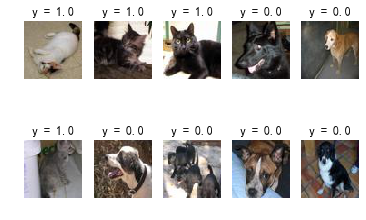

In [3]:
idx = [np.random.choice(m_train) for _ in range(10)]  # 随机选择 10 张图片
label = Y_train[idx]
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, 5*i+j+1)
        plt.imshow(X_train[idx[5*i+j]])
        plt.title("y = "+str(label[5*i+j]))
        plt.axis('off')
plt.show()

## 图片数据预处理

In [4]:
# 图片矩阵转化为一维向量
X_train = X_train.reshape(m_train, -1).T
X_test = X_test.reshape(m_test, -1).T

print('训练样本维度：' + str(X_train.shape))
print('测试样本维度：' + str(X_test.shape))

# 图片像素归一化到 [0,1] 之间
X_train = X_train / 255
X_test = X_test / 255

训练样本维度：(12288, 500)
测试样本维度：(12288, 200)


## 参数初始化

对于 $L$ 层神经网络，各层 $W^{[l]}$ 和 $b^{[l]}$ 都要初始化：$W^{[1]},b^{[1]},W^{[2]},b^{[2]},\cdots,W^{[L]},b^{[L]}$。

In [5]:
def initialize_parameters(layer_dims):
    """
    函数输入：
        - layer_dims：列表，神经网络各层神经元个数，包含输入层
    函数输出：
        - parameters：存储参数字典
    """
    
    np.random.seed(5)
    
    parameters = {}          # 存储参数 W 和 b 的字典
    L = len(layer_dims)      # 神经网络的层数，包含输入层

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.1    # 随机初始化
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))    # 初始化为零
       
    return parameters

## 前向传播

定义 Sigmoid 激活函数：

In [6]:
def sigmoid(Z):
    """
    函数输入：
        - Z：激活函数输入，神经元线性输出
    函数输出：
        - A：激活函数输出，神经元非线性输出
    """
    
    A = 1 / (1 + np.exp(-Z))
    
    return A

定义 ReLU 激活函数：

In [7]:
def relu(Z):
    """
    函数输入：
        - Z：激活函数输入，神经元线性输出
    函数输出：
        - A：激活函数输出，神经元非线性输出
    """
    
    A = np.maximum(0,Z)
    
    return A

单层神经网络计算 $Z$ 和 $A$：

In [8]:
def single_layer_forward(A_prev, W, b, activation):
    """
    函数输入：
        - A_prev：该层网络的输入，上一层网络的输出
        - W：该层网络的权重参数
        - b：该层网络的偏置参数
        - activation：该层网络使用的激活函数
    函数输出：
        - A：该层网络输出
        - cache：存储所有的中间变量 A_prev, W, b, Z
    """
    
    Z = np.dot(W, A_prev) + b        # 线性输出
    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "relu":
        A = relu(Z) 
    cache = (A_prev, W, b, Z)
    
    return A, cache

$L$ 层神经网络前向传播：

迭代更新公式：

$$Z^{[l]}=W^{[l]}A^{[l-1]}+b^{[l]}$$
$$A^{[l]}=g(Z^{[l]})$$

In [9]:
def forward_propagation(X, parameters):
    """
    函数输入：
        - X：神经网络输入
        - parameters：该层网络的权重参数
    函数输出：
        - A：该层网络输出
        - caches：存储各层网络所有的中间变量
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # 神经网络层数 L

    # L-1 层使用 ReLU
    for l in range(1, L):
        A_prev = A 
        A, cache = single_layer_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)

    # L 层使用 Sigmoid
    AL, cache = single_layer_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)

    return AL, caches

## 损失函数

交叉熵损失：

$$J=-\frac1m\sum_{i=1}^my^{(i)}log\hat y^{(i)}+(1-y^{(i)})log(1-\hat y^{(i)})$$

计算损失函数：

In [10]:
def compute_cost(AL, Y):
    """
    函数输入：
        - AL：神经网络输出层输出
        - Y：神经网络真实标签
    函数输出：
        - cost：交叉熵损失
    """

    m = AL.shape[1]
    cross_entropy = -(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = 1.0 / m * np.sum(cross_entropy)

    return cost

## 反向传播

反向传播梯度递推公式：

$$dZ^{[l]}=dA^{[l]}*g'(Z^{[l]})$$
$$ dW^{[l]} =  \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} =  \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)} $$
$$ dA^{[l-1]} =  W^{[l] T} dZ^{[l]} $$

定义 ReLU 函数的反向传播：dA --> dZ

In [11]:
def relu_backward(dA, Z):
    """
    函数输入：
        - dA：A 的梯度
        - Z：神经网络线性输出
    函数输出：
        - dZ：Z 的梯度
    """

    dZ = np.array(dA, copy=True)  
    dZ[Z <= 0] = 0

    return dZ

定义 Sigmoid 函数的反向传播：dA --> dZ

In [12]:
def sigmoid_backward(dA, Z):
    """
    函数输入：
        - dA：A 的梯度
        - Z：神经网络线性输出
    函数输出：
        - dZ：Z 的梯度
    """

    s = 1/(1 + np.exp(-Z))
    dZ = dA * s * (1-s)

    return dZ

单层神经网络反向传播：

In [13]:
def single_layer_backward(dA, cache, activation):
    """
    函数输入：
        - dA：A 的梯度
        - cache：存储所有的中间变量 A_prev, W, b, Z
        - activation：选择的激活函数
    函数输出：
        - dA_prev：上一层 A_prev 的梯度
        - dW：参数 W 的梯度
        - db：参数 b 的梯度
    """

    A_prev, W, b, Z = cache

    if activation == "relu":
        dZ = relu_backward(dA, Z)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, Z)

    m = dA.shape[1]
    dW = 1/m*np.dot(dZ,A_prev.T)
    db = 1/m*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)

    return dA_prev, dW, db

$L$ 层神经网络反向传播：

In [14]:
def backward_propagation(AL, Y, caches):
    """
    函数输入：
        - AL：神经网络输出层输出
        - cache：存储所有的中间变量 A_prev, W, b, Z
        - activation：选择的激活函数
    函数输出：
        - dA_prev：上一层 A_prev 的梯度
        - dW：参数 W 的梯度
        - db：参数 b 的梯度
    """

    grads = {}
    L = len(caches)         # 神经网络层数
    m = AL.shape[1]         # 样本个数
    
    # AL 值
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # 第 L 层，激活函数是 Sigmoid
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = single_layer_backward(dAL, current_cache, activation = "sigmoid")

    # 前 L-1 层，激活函数是 ReLU
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = single_layer_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

## 更新参数

In [15]:
def update_parameters(parameters, grads, learning_rate=0.1):
    """
    函数输入：
        - parameters: 网络参数
        - grads: 神经网络参数梯度
    函数输出：
        - parameters: 网络参数
    """
    
    L = len(parameters) // 2    # 神经网络层数 L
    for l in range(L):
        parameters['W'+str(l+1)] -= learning_rate * grads['dW'+str(l+1)]
        parameters['b'+str(l+1)] -=learning_rate * grads['db'+str(l+1)]
    
    return parameters

## 构建神经网络模型

定义整个模型：

In [16]:
def nn_model(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 3000):
    """
    函数输入：
        - X：神经网络输入
        - Y：样本真实标签
        - layers_dim: 列表，神经网络各层神经元个数，包含输入层和输出层
        - num_iterations: 训练次数
        - learning_rate: 学习率
    函数输出：
        - parameters: 训练完成后的网络参数
    """

    np.random.seed(1)
    costs = []                         

    # 参数初始化
    parameters = initialize_parameters(layers_dims)

    # 迭代训练
    for i in range(0, num_iterations):

        # 正向传播
        AL, caches = forward_propagation(X, parameters)

        # 计算损失函数
        cost = compute_cost(AL, Y)

        # 反向传播
        grads = backward_propagation(AL, Y, caches)

        # 更新参数
        parameters = update_parameters(parameters, grads, learning_rate)

        # 每迭代 100 次，打印 cost
        if (i+1) % 100 == 0:
            print ("Cost after iteration %i: %f" %(i+1, cost))
            costs.append(cost)

    # 绘制 cost 趋势图
    plt.plot(np.squeeze(costs))
    plt.ylabel('交叉熵损失cost')
    plt.xlabel('迭代训练次数（百次）')
    plt.show()

    return parameters

定义预测函数：

In [17]:
def predict(X, parameters):
    """
    函数输入：
        - X：神经网络输入
        - parameters: 训练完成后的网络参数
    函数输出：
        - Y_pred: 预测样本标签
    """
    
    # L 层模型前向传播
    AL, caches = forward_propagation(X, parameters)
    # 预测标签
    Y_pred = np.zeros((1, X.shape[1]))    # 初始化 Y_pred
    Y_pred[AL > 0.5] = 1    # Y_hat 大于 0.5 的预测为正类
    
    return Y_pred

### 使用简单的 2 层神经网络训练

训练：

Cost after iteration 100: 0.684486
Cost after iteration 200: 0.674664
Cost after iteration 300: 0.662584
Cost after iteration 400: 0.646598
Cost after iteration 500: 0.626021
Cost after iteration 600: 0.600818
Cost after iteration 700: 0.573096
Cost after iteration 800: 0.542202
Cost after iteration 900: 0.508659
Cost after iteration 1000: 0.486468
Cost after iteration 1100: 0.476841
Cost after iteration 1200: 0.459816
Cost after iteration 1300: 0.440341
Cost after iteration 1400: 0.422442
Cost after iteration 1500: 0.401162
Cost after iteration 1600: 0.379927
Cost after iteration 1700: 0.350352
Cost after iteration 1800: 0.341812
Cost after iteration 1900: 0.323652
Cost after iteration 2000: 0.299465


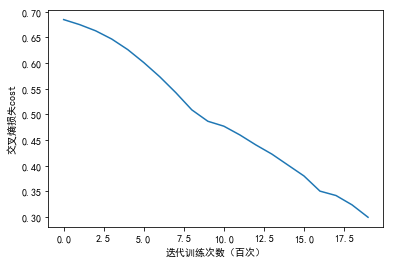

In [18]:
layers_dims = [12288, 10, 1]    # 2-layer model
parameters = nn_model(X_train, Y_train, layers_dims, 
                      num_iterations=2000, 
                      learning_rate=0.01)

计算训练样本的准确率：

In [19]:
Y_train_pred = predict(X_train, parameters)
acc_train = np.mean(Y_train_pred == Y_train)
print(acc_train)

0.858


计算测试样本的准确率：

In [20]:
Y_test_pred = predict(X_test, parameters)
acc_test = np.mean(Y_test_pred == Y_test)
print(acc_test)

0.57


### 使用更深的 5 层神经网络训练

Cost after iteration 100: 0.688680
Cost after iteration 200: 0.678262
Cost after iteration 300: 0.644802
Cost after iteration 400: 0.610248
Cost after iteration 500: 0.568977
Cost after iteration 600: 0.505714
Cost after iteration 700: 0.434559
Cost after iteration 800: 0.303987
Cost after iteration 900: 0.343186
Cost after iteration 1000: 0.089528
Cost after iteration 1100: 0.028418
Cost after iteration 1200: 0.014516
Cost after iteration 1300: 0.008889
Cost after iteration 1400: 0.006102
Cost after iteration 1500: 0.004537
Cost after iteration 1600: 0.003547
Cost after iteration 1700: 0.002877
Cost after iteration 1800: 0.002404
Cost after iteration 1900: 0.002041
Cost after iteration 2000: 0.001767


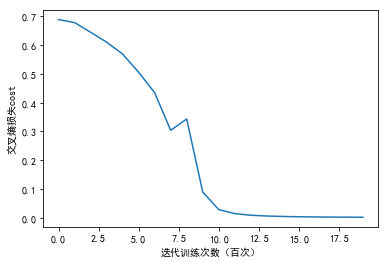

In [21]:
layers_dims = [12288, 200, 100, 20, 6, 1] #  5-layer model
parameters = nn_model(X_train, Y_train, layers_dims, 
                      num_iterations=2000, 
                      learning_rate=0.02)

预测，计算训练样本的准确率：

In [22]:
Y_train_pred = predict(X_train, parameters)
acc_train = np.mean(Y_train_pred == Y_train)
print(acc_train)

1.0


计算测试样本的准确率：

In [23]:
Y_test_pred = predict(X_test, parameters)
acc_test = np.mean(Y_test_pred == Y_test)
print(acc_test)

0.64
